<a href="https://colab.research.google.com/github/wenbowanghaha/ML/blob/master/Final_project_Wenbo_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

### Wenbo Wang

### Project briefing: 

This project will load CIFAR-10 data set from TensorFlow.Keras. This data set is well researched and suitable for the research on computer vision. The mission for this project is to practice implementing deep neural networks with TensorFlow 2.0 backend and its Keras APIs. Some of the codes will be reference from the textbook: Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow 2nd Edition. In this project, there will be multiple models to implement and compare the performance, and then select the best model to make predictions on the test set for only once. 

# Load libs

In [0]:
# this will ensure using TensorFlow 2.x version on Google Colab
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import print_summary, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import os

In [2]:
# check out tf version
tf.__version__

'2.0.0'

In [3]:
# check out keras version
keras.__version__

'2.2.4-tf'

# Some constants and utility functions

In [0]:
batch_size = 64 # You can try 64 or 128 if you'd like to
num_classes = 10
epochs = 50
validation_size = 0.2

input_shape = (32, 32, 3)

# plot learning curves
def plot_learning_curves(history):
    # plot loss
    plt.figure(figsize=(8, 5))
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='Train Set')
    plt.plot(history.history['val_loss'], color='orange', label='Validation Set')
    plt.legend(loc="upper right")
    plt.show()
    # plot accuracy
    plt.figure(figsize=(8, 5))
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='Train Set')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validation Set')
    plt.legend(loc="lower right")
    plt.show()

# def get_class_from_softmax(softmax_list):
#     # write your own "argmax" function 
#     return max_index

# Load data and inspect data set

In [0]:
# then load the data set
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()  # You can use this method to get the data
                                                            # It will work locally and colab as well

# also store the label names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# check out the size of the loaded data set
print('X_train_full size = ', X_train_full.shape)
print('y_train_full size = ', y_train_full.shape)
print('X_test size = ', X_test.shape)
print('y_test size = ', y_test.shape)

X_train_full size =  (50000, 32, 32, 3)
y_train_full size =  (50000, 1)
X_test size =  (10000, 32, 32, 3)
y_test size =  (10000, 1)


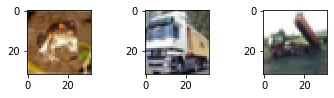

In [7]:
# then plot some train set images
num_images = 3

for i in range(num_images):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train_full[i])
plt.show()

### So we can see that the images in the data set are low resolution images, which could mean the classification would be affected by this. 

In [8]:
# check out the data type of the instance
X_train_full.dtype

dtype('uint8')

In [9]:
# check out label
some_index = 0

y_train_full[some_index]

array([6], dtype=uint8)

In [10]:
# show the class name
label_names[y_train_full[some_index][0]]

'frog'

# Data preprocessing

### Need to convert the label to one hot vector (optional)

In [0]:
# conver label to one hot vector
# y_train_full = to_categorical(y_train_full)
# y_test = to_categorical(y_test)

### Since the training of NN will use GD, so must scale the input features. For simplicity, just normalize by dividing each feature by 255.0, which will also turn each feature into float number. Also need to split the training set into sub training set and validation set. 

In [12]:
# normalize
X_train_full_norm = X_train_full / 255.0

# split into sub training set and validation set
validation_cutoff = int(len(X_train_full) * validation_size)
X_train, X_vali = X_train_full_norm[validation_cutoff:], \
                  X_train_full_norm[:validation_cutoff]
y_train, y_vali = y_train_full[validation_cutoff:], \
                  y_train_full[:validation_cutoff]

print(X_train.shape)
print(X_vali.shape)
print(y_train.shape)
print(y_vali.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)


# Modeling

### In this section, will try out different models, build them, compile them, train them and evaluate them. This will start from very basic model, like the one in the book, and some other models inspired from other resources, which will have reference info. To build the model, use Sequential API like in the book. 

### 1. Classification MLP using Sequential API

#### This model is very basic model. Ref: Hands-On Machine Learning text book. The model will have input layer to flatten the input images, and then there will be two hidden layers, which have different neurons and use ReLU activation function since its performance is good as default function, then the output layer will have 10 neurons, and since this is multiclass classification task and the labels are exclusive, so the activation function is softmax. When compile the model, use SGD with custom learning rate as optimizer, and accuracy as the metric for both training set and validation set. Also set the loss function to sparse_categorical_crossentropy since there are sparse labels and they are exclusive like mentioned before. 

In [0]:
# define model
def define_model_book():
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_uniform"))
  model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform"))
  model.add(keras.layers.Dense(num_classes, activation="softmax"))
  # compile model
  opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, 
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
  return model

In [14]:
# initialize model
model_book = define_model_book()
# fit model
history_book = model_book.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_vali, y_vali))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 69us/sample - loss: 1.9392 - accuracy: 0.3115 - val_loss: 1.7961 - val_accuracy: 0.3627
Epoch 2/50
40000/40000 [==============================] - 2s 53us/sample - loss: 1.7673 - accuracy: 0.3768 - val_loss: 1.7413 - val_accuracy: 0.3712
Epoch 3/50
40000/40000 [==============================] - 2s 53us/sample - loss: 1.6905 - accuracy: 0.4018 - val_loss: 1.6607 - val_accuracy: 0.4085
Epoch 4/50
40000/40000 [==============================] - 2s 52us/sample - loss: 1.6360 - accuracy: 0.4248 - val_loss: 1.6252 - val_accuracy: 0.4236
Epoch 5/50
40000/40000 [==============================] - 2s 54us/sample - loss: 1.5955 - accuracy: 0.4388 - val_loss: 1.5775 - val_accuracy: 0.4375
Epoch 6/50
40000/40000 [==============================] - 2s 53us/sample - loss: 1.5616 - accuracy: 0.4502 - val_loss: 1.5418 - val_accuracy: 0.4542
Epoch 7/50
40000/40000 [==============================] 

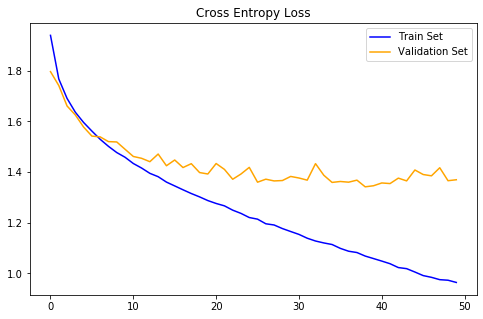

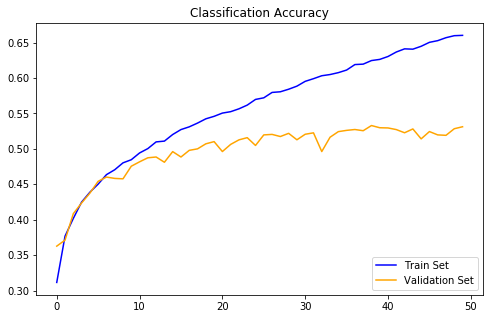

In [15]:
# then plot the learning curves
plot_learning_curves(history_book)

In [16]:
# then evaluate the model on the full training set and print out the accuracy
print("Full training set accuracy: ", 
      "%.3f" % (model_book.evaluate(X_train_full, y_train_full)[1] * 100.0), "%")

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [30]:
# then evaluate the model on the validation set and print out the accuracy
print("Validation set accuracy: ", 
      "%.3f" % (model_book.evaluate(X_vali, y_vali)[1] * 100.0), "%")

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Thoughts on this model: 

As you can see, the accuracy is not good, just over 50% and from the above plots we can see that for both loss and accuracy, the performance on training set is much better than on validation set, suggesting that the model is severely overfitting on the training set, so we should regularize it, or add more data, which maybe harder, or use a less complicated model. Also as can be seen here, the number of epochs may not be enough as the loss on training set is still in the downward trend and accuracy on training set is still rising up, so maybe try fitting with larger number of epochs. But let's move on to next model. 

### 2. VGG CNN model

This CNN model refers to a deep convolutional network for object recognition developed and trained by Oxford's renowned Visual Geometry Group (VGG), which achieved very good performance on the ImageNet dataset. The previous information can be found here: "https://www.quora.com/What-is-the-VGG-neural-network". There can be multiple stacks in this model, such as VGG-1, VGG-16, but in this project let's just implement 3 stacks VGG CNN model to illustrate the purpose. Again, use Sequential API to implement this model. 

In [0]:
# define VGG-3 CNN model
def define_model_vgg():
    model = keras.models.Sequential()
    # add VGG stacks here
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # the following part is the same as the book model
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_uniform"))
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))
    # compile model
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [18]:
# initialize model
model_vgg = define_model_vgg()
# fit model
history_vgg = model_vgg.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_vali, y_vali))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 6s 150us/sample - loss: 1.7725 - accuracy: 0.3554 - val_loss: 1.5747 - val_accuracy: 0.4237
Epoch 2/50
40000/40000 [==============================] - 4s 110us/sample - loss: 1.4531 - accuracy: 0.4755 - val_loss: 1.3708 - val_accuracy: 0.5089
Epoch 3/50
40000/40000 [==============================] - 4s 109us/sample - loss: 1.2920 - accuracy: 0.5365 - val_loss: 1.2681 - val_accuracy: 0.5464
Epoch 4/50
40000/40000 [==============================] - 4s 110us/sample - loss: 1.1599 - accuracy: 0.5856 - val_loss: 1.1550 - val_accuracy: 0.5878
Epoch 5/50
40000/40000 [==============================] - 4s 111us/sample - loss: 1.0691 - accuracy: 0.6226 - val_loss: 1.0817 - val_accuracy: 0.6139
Epoch 6/50
40000/40000 [==============================] - 4s 110us/sample - loss: 0.9684 - accuracy: 0.6610 - val_loss: 1.0680 - val_accuracy: 0.6169
Epoch 7/50
40000/40000 [==========================

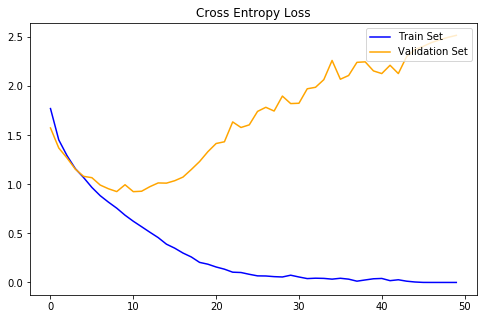

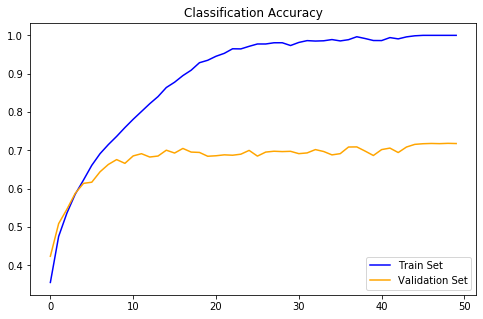

In [19]:
# then plot the learning curves
plot_learning_curves(history_vgg)

In [20]:
# then evaluate the model on the full training set and print out the accuracy
print("Full training set accuracy: ", 
      "%.3f" % (model_vgg.evaluate(X_train_full, y_train_full)[1] * 100.0), "%")

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [31]:
# then evaluate the model on the validation set and print out the accuracy
print("Validation set accuracy: ", 
      "%.3f" % (model_vgg.evaluate(X_vali, y_vali)[1] * 100.0), "%")

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Thoughts on this model:

Well, this model is much better than the demo model in the book. First of all, VGG CNN model is one of the top models in the industry right now, so there is little doubt on the performance on this model. The accuracy on the full training set is over 80%, which is quite impressive. There is, however, the same problem as the book model, which is the overfitting on the training model. As you can see, only after about 8 epochs, then the performances on training set and validation set start to split and at the end of the training, there is a large gap between two sets, suggesting a major overfitting problem. So let's put in some regularizations on this model and see what we can improve on this model. 

### 3. VGG-3 CNN model with regularizations

For the regularizations, it seems that early stop will not work well since the model diverged too soon and ways to slow down the rate of convergence could help, so let's do the following: 
1. Dropout regularizaion: this will randomly drop nodes out of the NN, so that remaining nodes will continue from what left by the dropped out nodes. We will add dropout layer to each stack with fixed dropout rate, which is 20% for now. 
2. Weight decay: this will update the loss function to penalize the model in proportion to the size of the model weights, meaning that weights will be smaller and smaller weights are often more stable and more general. We can add L2 regularization to convolutional layers and dense layers, with default weighting of 0.001. 

Will train two models for two regularizations. 

#### 1) Dropout version

In [0]:
# define VGG-3 CNN model with dropout regularization
def define_model_vgg_dropout():
    model = keras.models.Sequential()
    # add VGG stacks here
    # also add regularization, adding dropout layer for this model
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    # the following part is the same as the book model
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_uniform"))
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dropout(0.2))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))
    # compile model
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [22]:
# initialize model
model_vgg_dropout = define_model_vgg_dropout()
# fit model
history_vgg_dropout = model_vgg_dropout.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_vali, y_vali))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 5s 132us/sample - loss: 2.0512 - accuracy: 0.2340 - val_loss: 1.7512 - val_accuracy: 0.3418
Epoch 2/50
40000/40000 [==============================] - 5s 116us/sample - loss: 1.7208 - accuracy: 0.3602 - val_loss: 1.5823 - val_accuracy: 0.4315
Epoch 3/50
40000/40000 [==============================] - 5s 114us/sample - loss: 1.5710 - accuracy: 0.4191 - val_loss: 1.4119 - val_accuracy: 0.4802
Epoch 4/50
40000/40000 [==============================] - 5s 115us/sample - loss: 1.4719 - accuracy: 0.4622 - val_loss: 1.3723 - val_accuracy: 0.4906
Epoch 5/50
40000/40000 [==============================] - 5s 118us/sample - loss: 1.3891 - accuracy: 0.4965 - val_loss: 1.2701 - val_accuracy: 0.5363
Epoch 6/50
40000/40000 [==============================] - 5s 117us/sample - loss: 1.3214 - accuracy: 0.5209 - val_loss: 1.2159 - val_accuracy: 0.5607
Epoch 7/50
40000/40000 [==========================

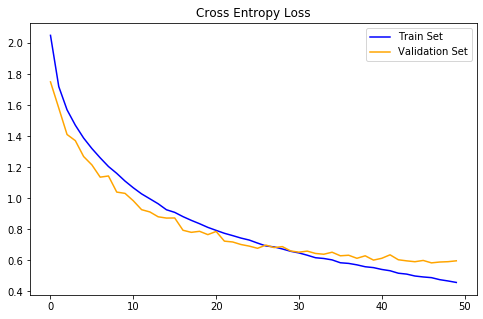

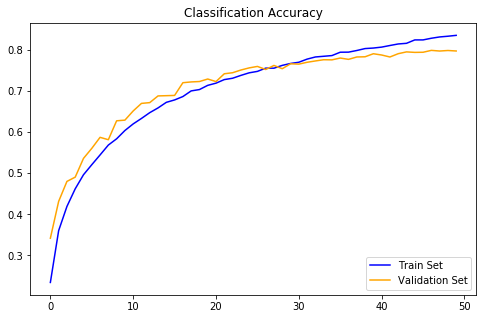

In [23]:
# then plot the learning curves
plot_learning_curves(history_vgg_dropout)

In [29]:
# then evaluate the model on the full training set and print out the accuracy
print("Full training set accuracy: ", 
      "%.3f" % (model_vgg_dropout.evaluate(X_train_full, y_train_full)[1] * 100.0), "%")

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
# then evaluate the model on the validation set and print out the accuracy
print("Validation set accuracy: ", 
      "%.3f" % (model_vgg_dropout.evaluate(X_vali, y_vali)[1] * 100.0), "%")

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### 2) Weight decay version

In [0]:
# define VGG-3 CNN model with weight decay regularization
def define_model_vgg_weight_decay():
    model = keras.models.Sequential()
    # add VGG stacks here
    # also add regularization, adding weight decay for this model
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    # the following part is the same as the book model
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_uniform", kernel_regularizer=l2(0.001)))
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform", kernel_regularizer=l2(0.001)))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))
    # compile model
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

In [26]:
# initialize model
model_vgg_weight_decay = define_model_vgg_weight_decay()
# fit model
history_vgg_weight_decay = model_vgg_weight_decay.fit(X_train, y_train, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_vali, y_vali))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 5s 137us/sample - loss: 3.5501 - accuracy: 0.3209 - val_loss: 3.2162 - val_accuracy: 0.4302
Epoch 2/50
40000/40000 [==============================] - 5s 117us/sample - loss: 3.1009 - accuracy: 0.4761 - val_loss: 3.0082 - val_accuracy: 0.5027
Epoch 3/50
40000/40000 [==============================] - 5s 116us/sample - loss: 2.8852 - accuracy: 0.5462 - val_loss: 2.8631 - val_accuracy: 0.5504
Epoch 4/50
40000/40000 [==============================] - 5s 119us/sample - loss: 2.7348 - accuracy: 0.5898 - val_loss: 2.7033 - val_accuracy: 0.5918
Epoch 5/50
40000/40000 [==============================] - 5s 116us/sample - loss: 2.5960 - accuracy: 0.6300 - val_loss: 2.5400 - val_accuracy: 0.6382
Epoch 6/50
40000/40000 [==============================] - 5s 116us/sample - loss: 2.4852 - accuracy: 0.6585 - val_loss: 2.5215 - val_accuracy: 0.6418
Epoch 7/50
40000/40000 [==========================

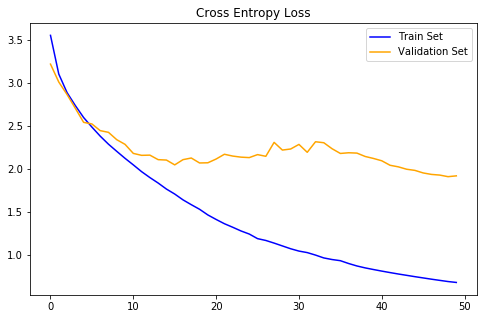

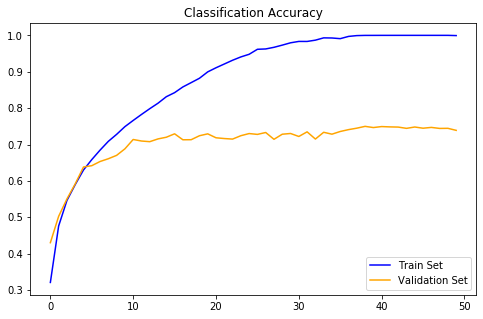

In [27]:
# then plot the learning curves
plot_learning_curves(history_vgg_weight_decay)

In [28]:
# then evaluate the model on the full training set and print out the accuracy
print("Full training set accuracy: ", 
      "%.3f" % (model_vgg_weight_decay.evaluate(X_train_full, y_train_full)[1] * 100.0), "%")

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [33]:
# then evaluate the model on the validation set and print out the accuracy
print("Validation set accuracy: ", 
      "%.3f" % (model_vgg_weight_decay.evaluate(X_vali, y_vali)[1] * 100.0), "%")

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Thoughts on the two regularizations: 

As you can see, with help of regularizations, there are some differences on the model. 
1. Dropout regularization: overfitting has been addressed really well as the model converges for about 40 or 50 epochs, then we could do more on this model, like early stopping or learning schedule, or even grid search on hyperparameters in the later work. The validation set accuracy is the best on this model so far. 
2. Weight decay: this has not addressed the overfitting on this model and the accuracy on validation set is not as good as the model with dropout, so should try other values on the hyperparameters. 
3. So currently, we can choose VGG CNN model with dropout regularization as our final model to move on. 

# Save model and load the final model

In [0]:
#Save model
model_vgg_dropout.save('my_model.h5', overwrite=True)
# Here we'll use the model to classify the test set!
final_model = load_model('my_model.h5')








# Use the final model to make predictions on the test set

In [36]:
# preprocess on the test set first
X_test_norm = X_test / 255.0

# then evaluate the final model on the test set and print out the accuracy
print("Test set accuracy: ", 
      "%.3f" % (final_model.evaluate(X_test_norm, y_test)[1] * 100.0), "%")

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

So the accuracy score on the test set is as good as the model on validation set, meaning the performance is just within the expectation. 

In [45]:
#But you don't learn anything above, just the raw accuracy score.
# Here please use the following imports to create a confusion matrix and 
# A classification report

# first, should make predictions with the model
y_pred = final_model.predict_classes(X_test_norm)

# then generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[796,  14,  21,  20,  11,   5,   4,   7,  83,  39],
       [  9, 887,   1,   1,   0,   2,   3,   1,  30,  66],
       [ 64,   4, 642,  57,  81,  65,  46,  12,  19,  10],
       [ 15,  10,  39, 609,  40, 173,  44,  21,  23,  26],
       [ 12,   4,  33,  55, 769,  31,  41,  39,  11,   5],
       [  9,   5,  18, 137,  34, 742,  12,  24,   7,  12],
       [  5,   3,  10,  54,  23,  22, 868,   5,   7,   3],
       [ 16,   2,  16,  37,  39,  58,   4, 814,   4,  10],
       [ 27,  16,   2,   5,   2,   1,   2,   2, 933,  10],
       [ 15,  66,   3,   9,   1,   0,   1,   2,  25, 878]])

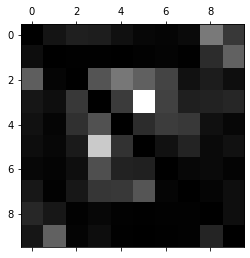

In [46]:
# then have a better understanding of the confusion matrix via matshow()
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

np.fill_diagonal(norm_conf_matrix, 0)

plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

With this matshow image, we can better understand what the error this models make and may offer some insights as what can we do to further improve the model. 

In [47]:
# then generate classificaton report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.82      0.80      0.81      1000\n           1       0.88      0.89      0.88      1000\n           2       0.82      0.64      0.72      1000\n           3       0.62      0.61      0.61      1000\n           4       0.77      0.77      0.77      1000\n           5       0.68      0.74      0.71      1000\n           6       0.85      0.87      0.86      1000\n           7       0.88      0.81      0.84      1000\n           8       0.82      0.93      0.87      1000\n           9       0.83      0.88      0.85      1000\n\n    accuracy                           0.79     10000\n   macro avg       0.80      0.79      0.79     10000\nweighted avg       0.80      0.79      0.79     10000\n'